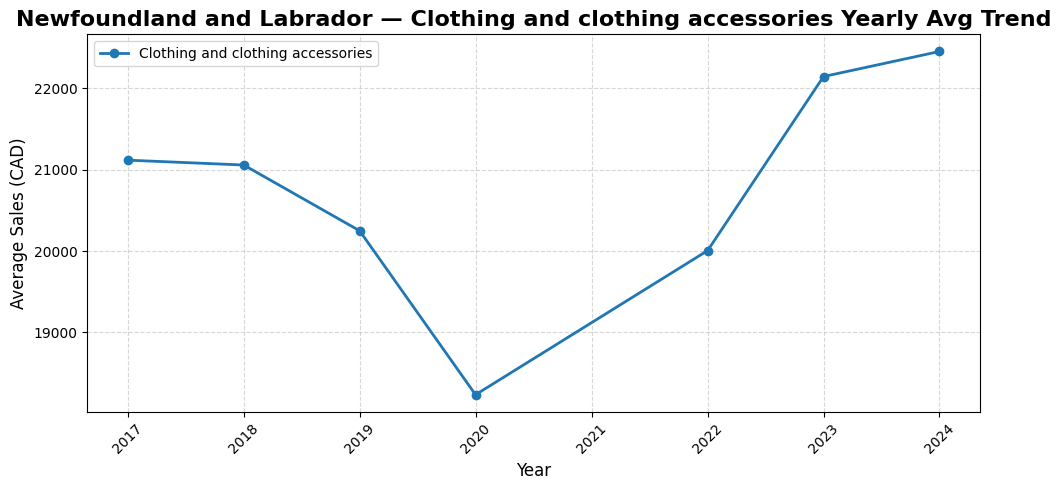

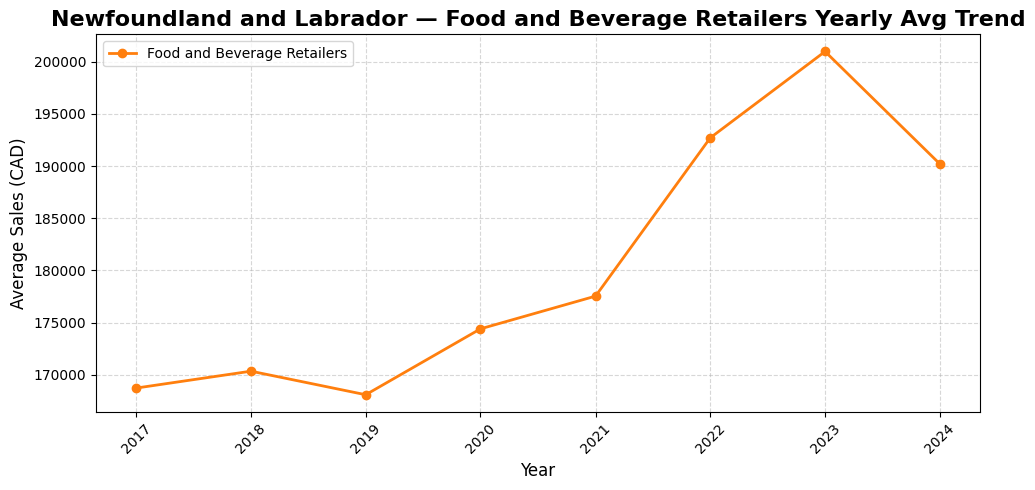

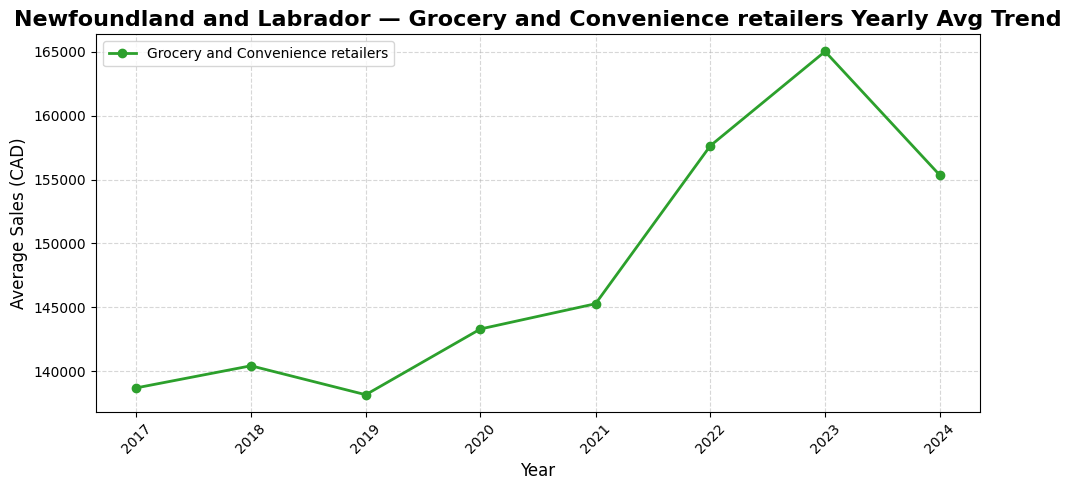

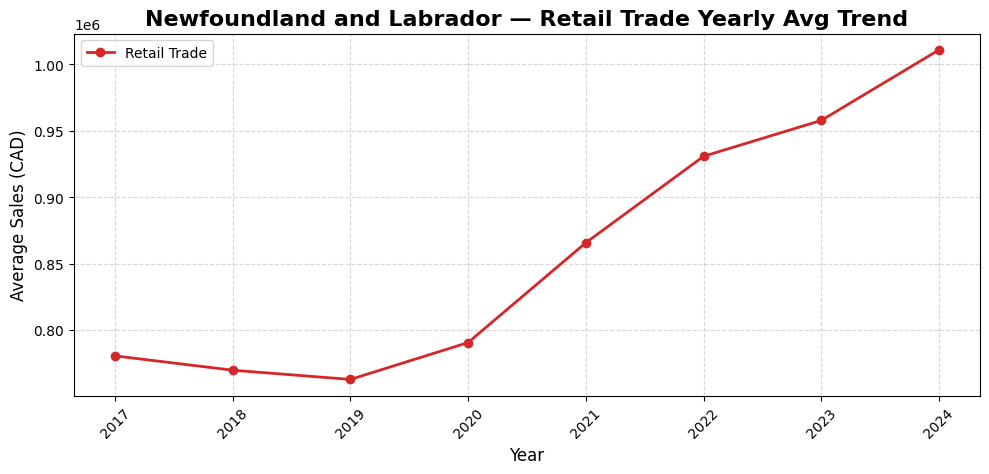

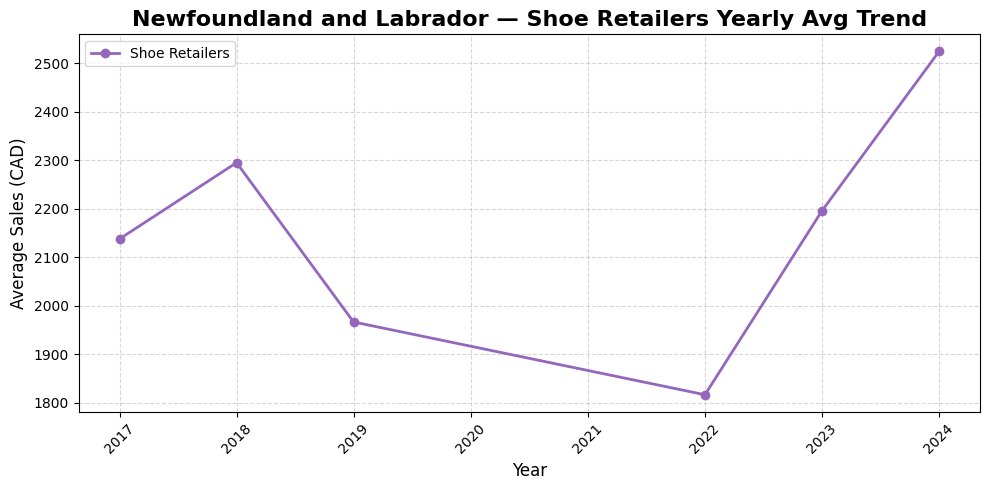

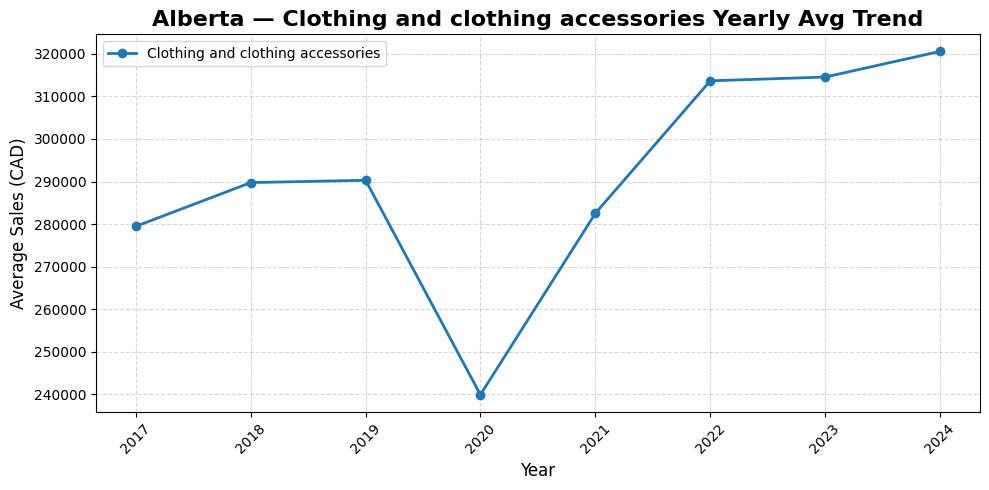

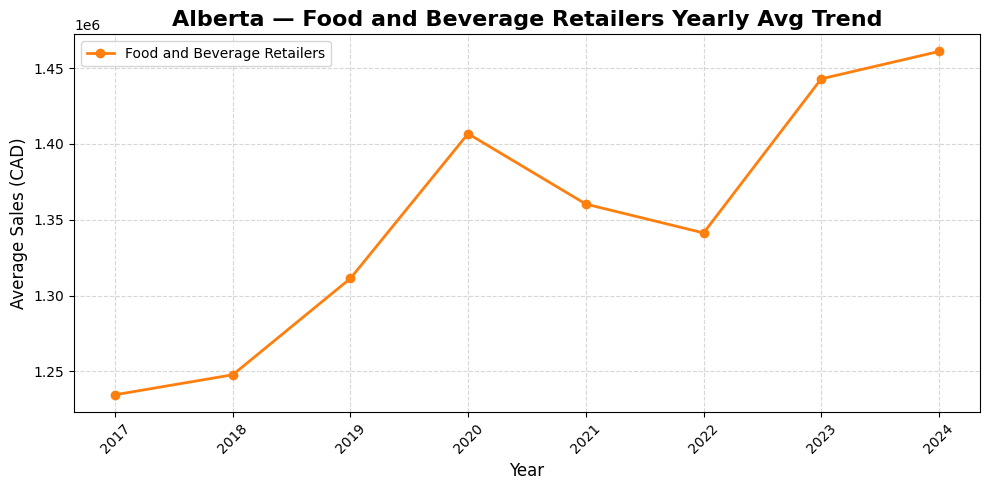

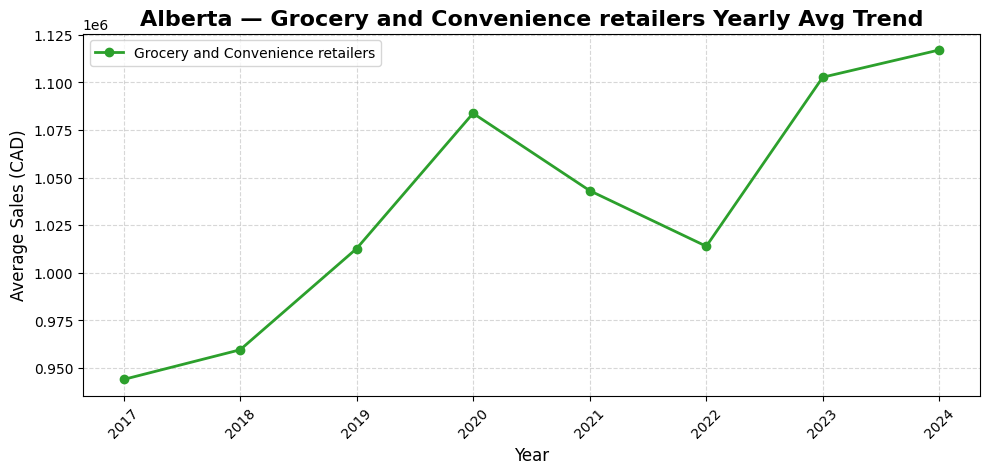

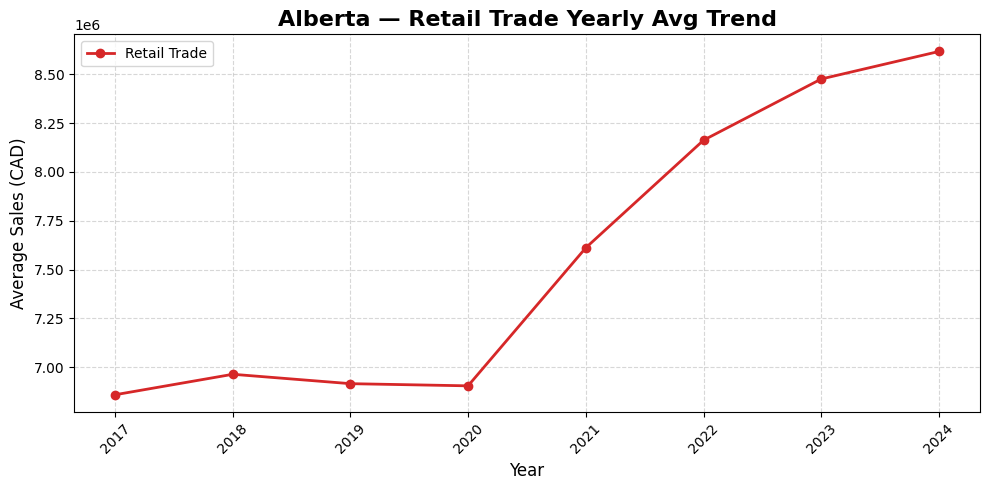

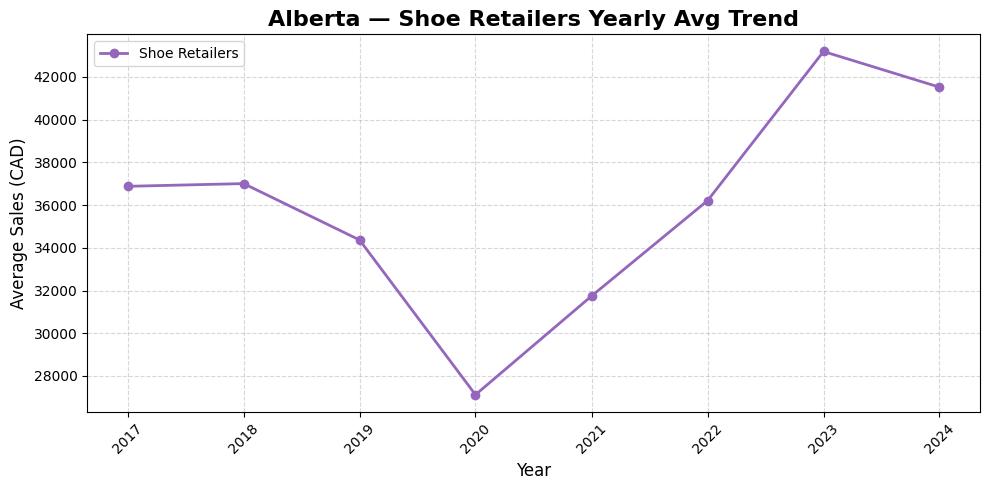

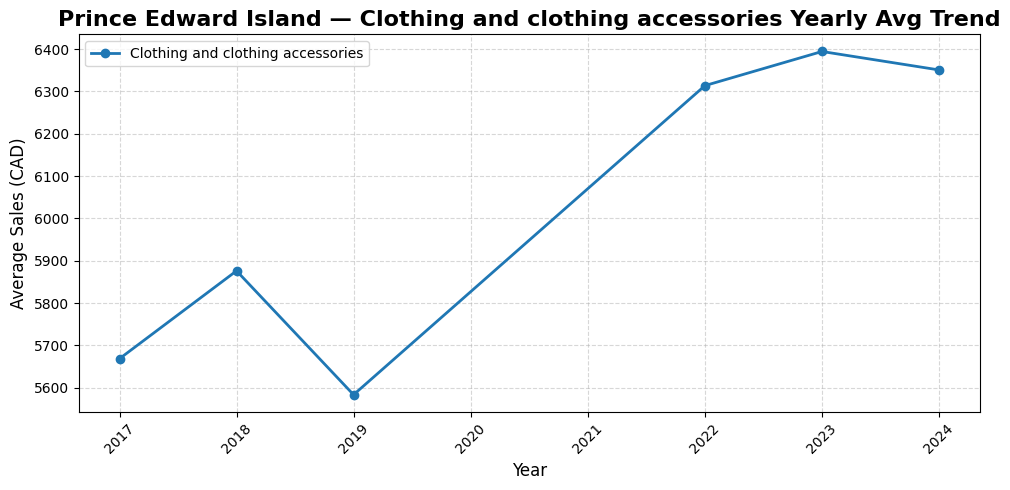

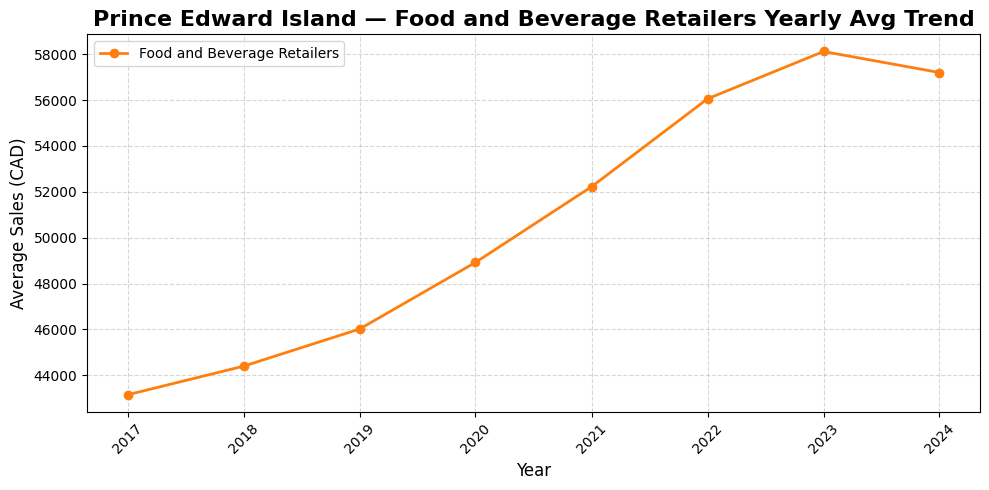

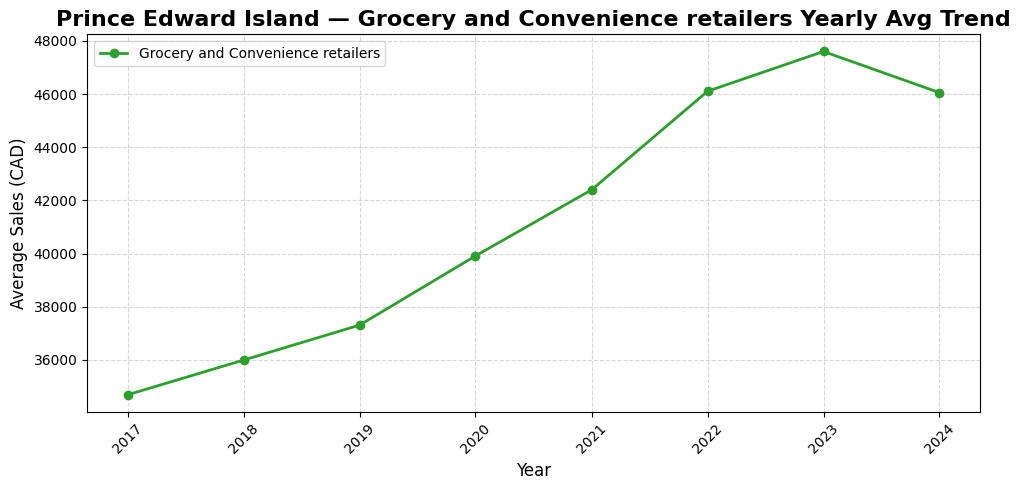

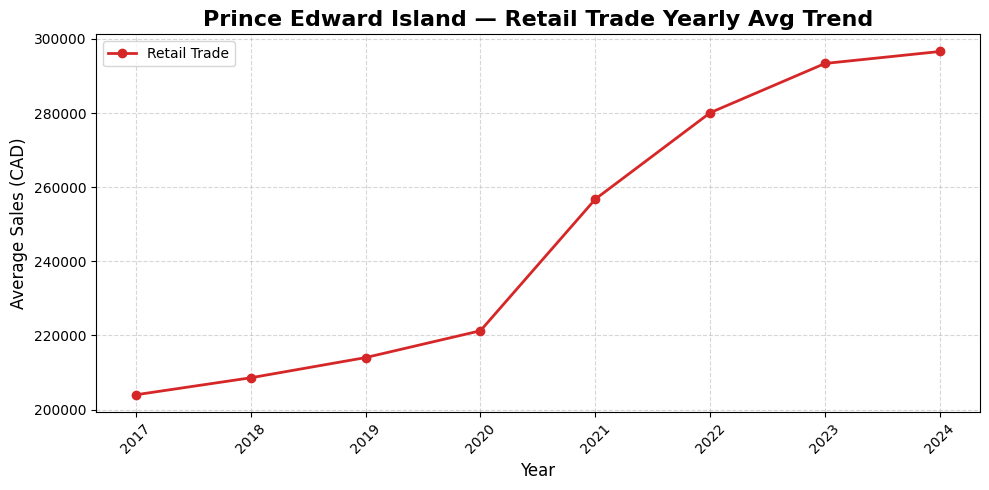

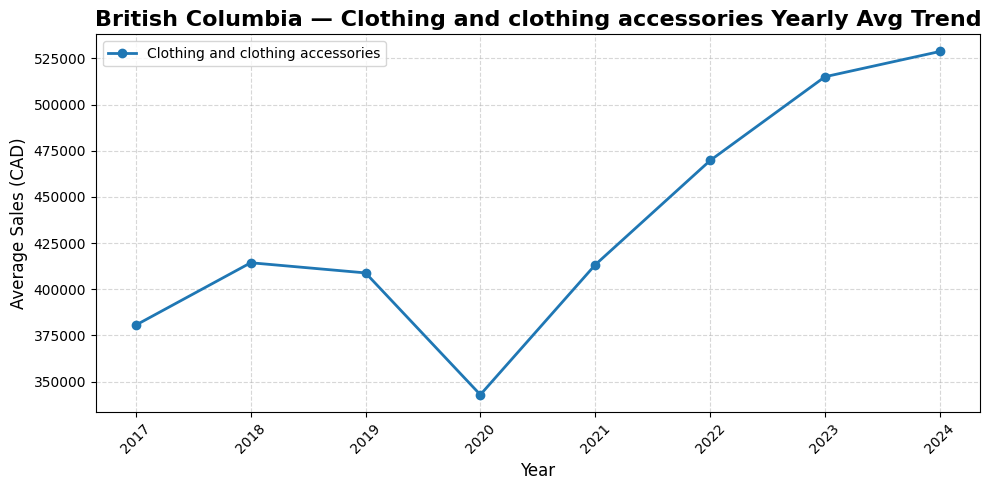

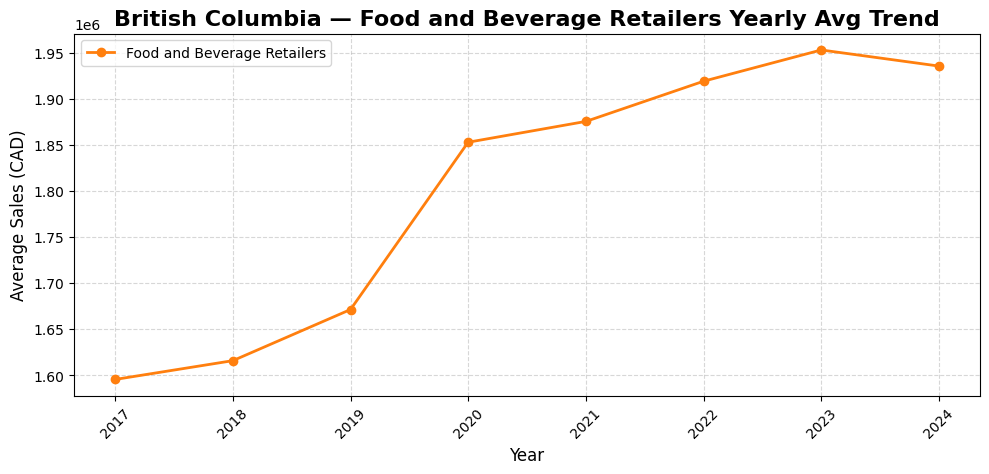

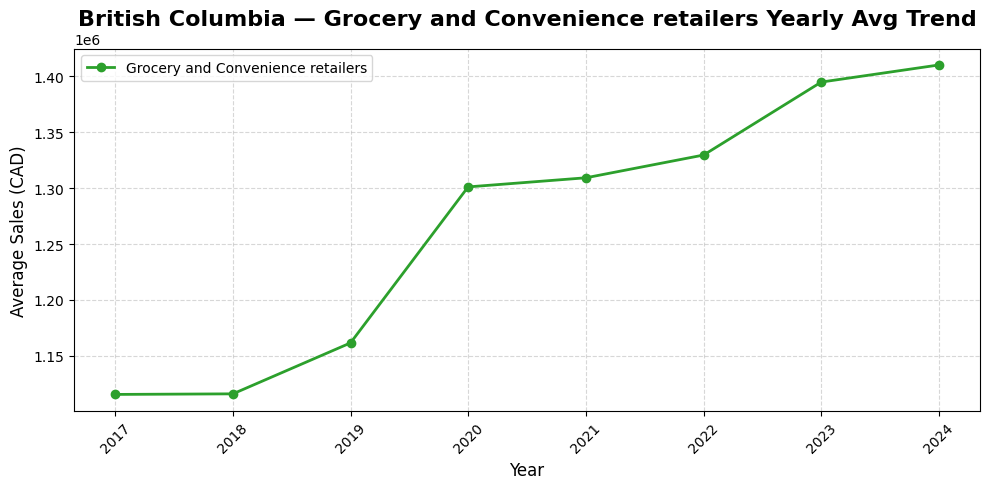

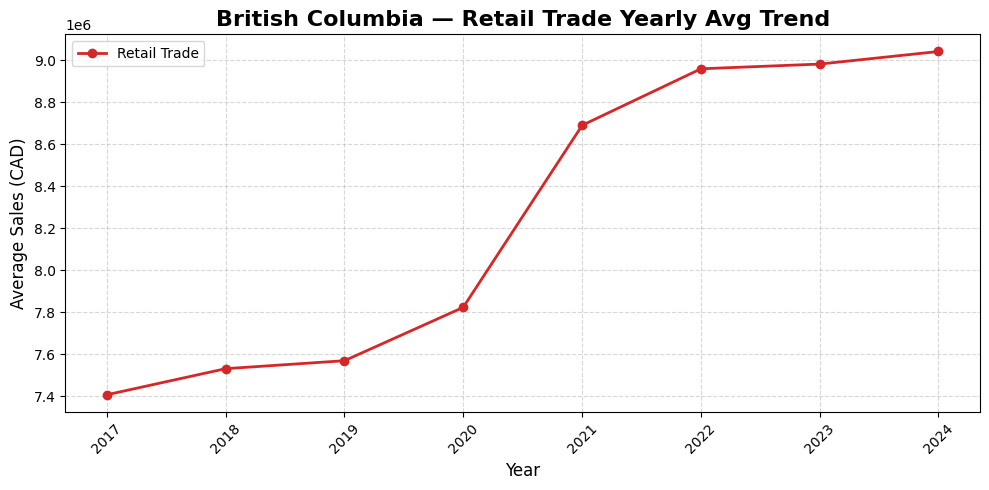

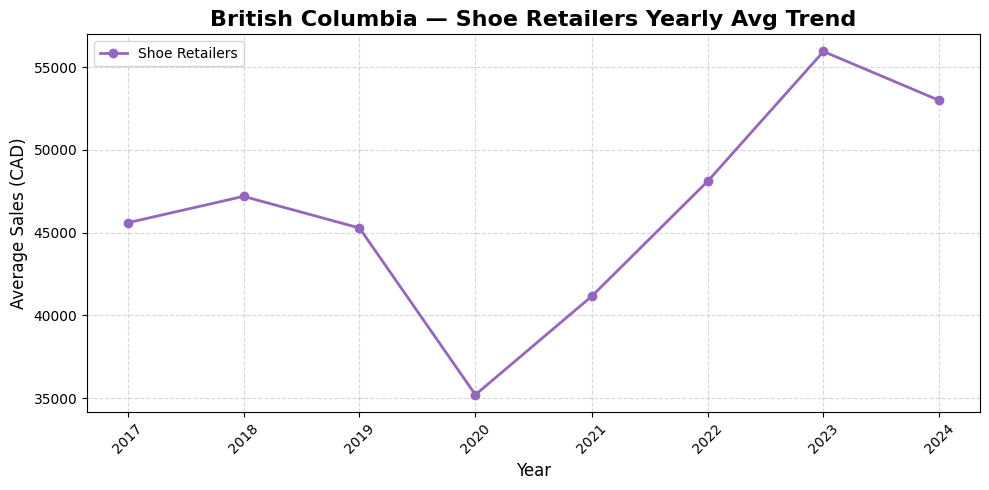

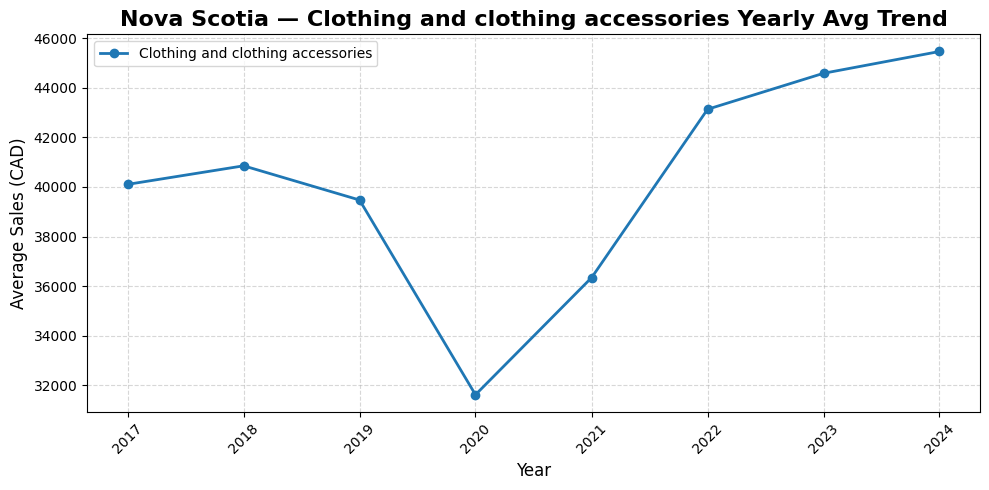

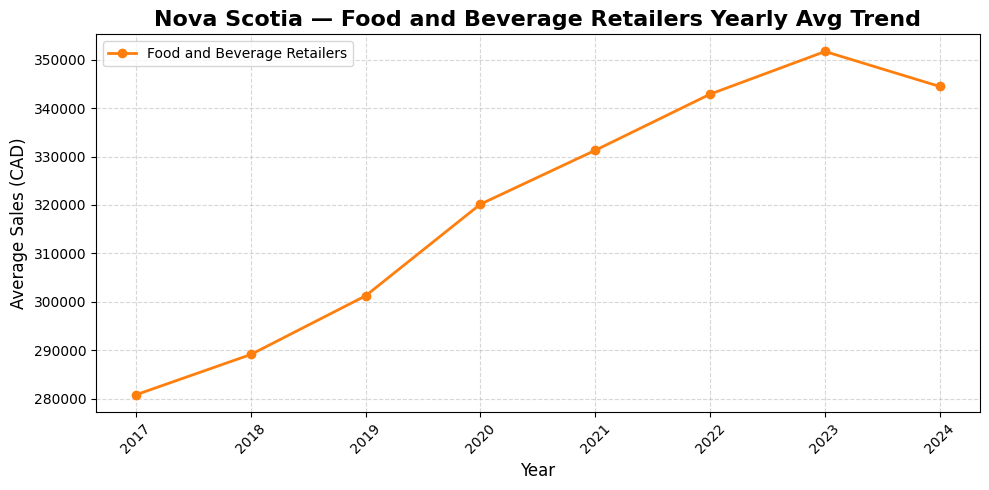

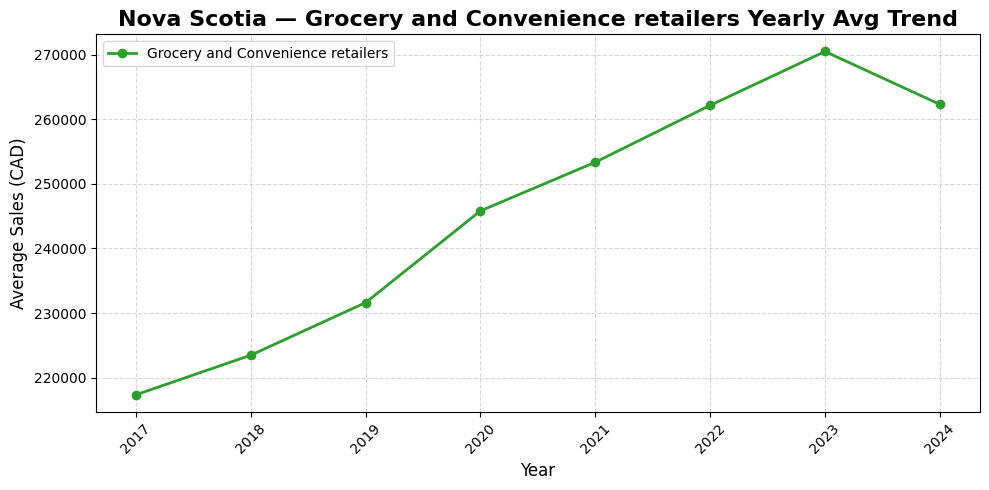

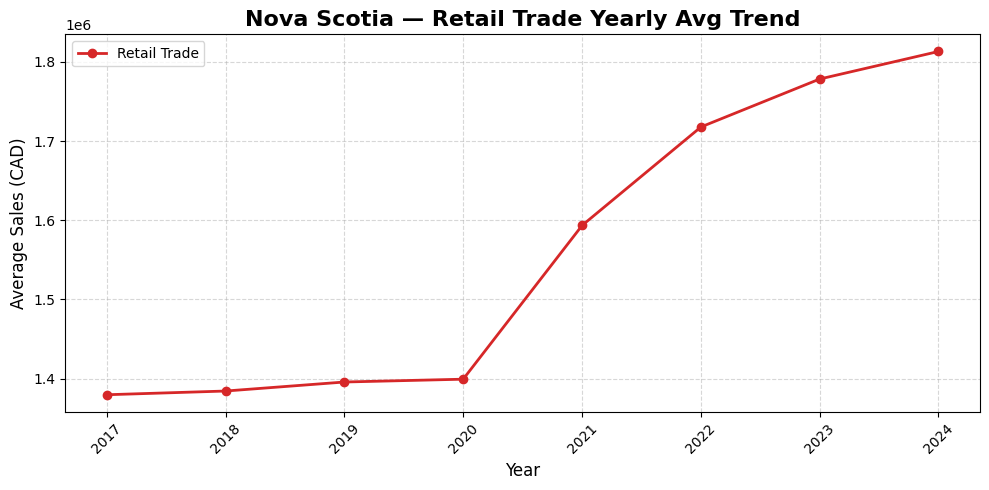

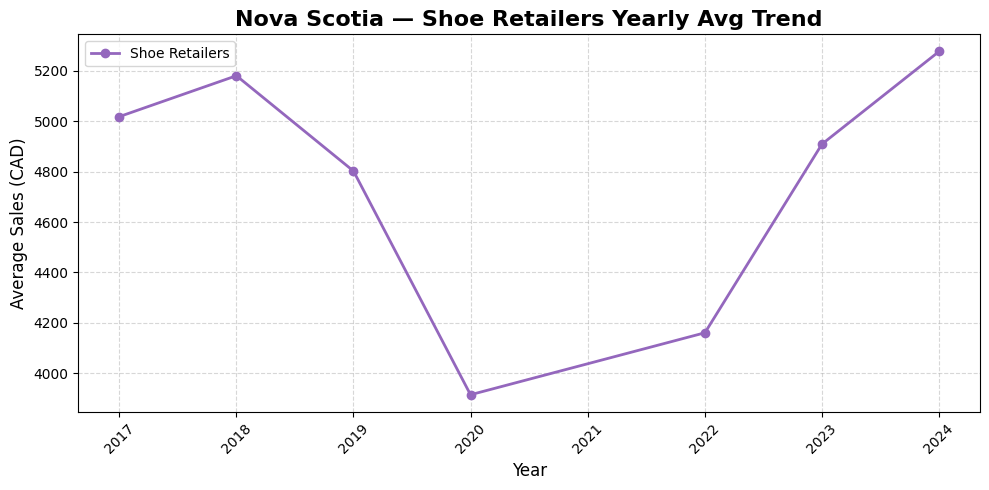

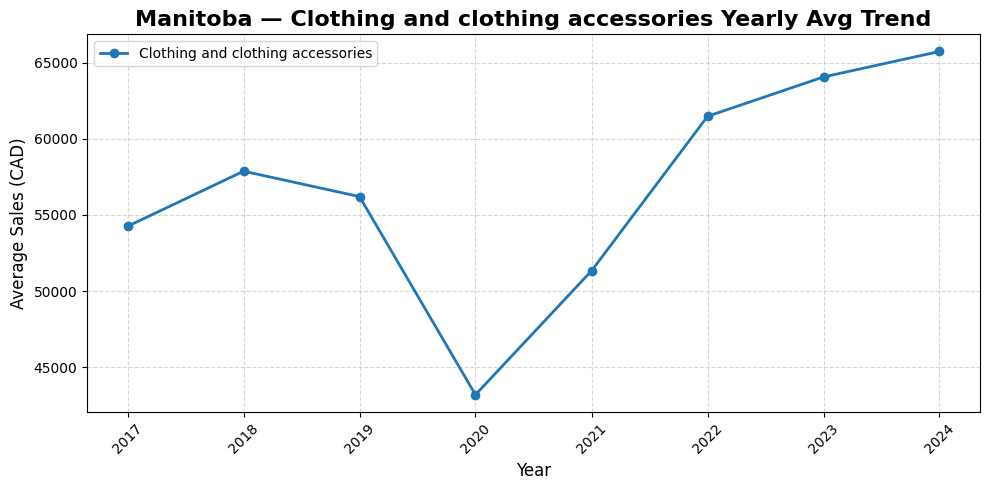

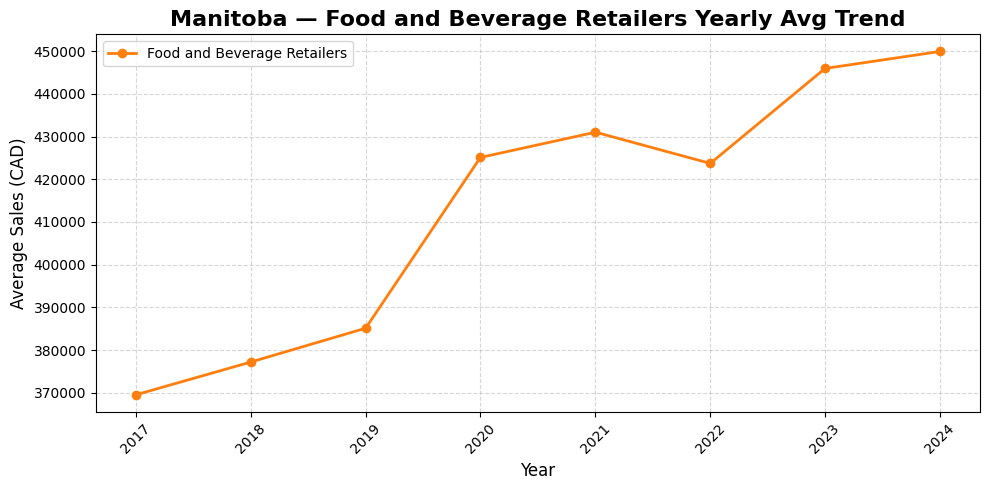

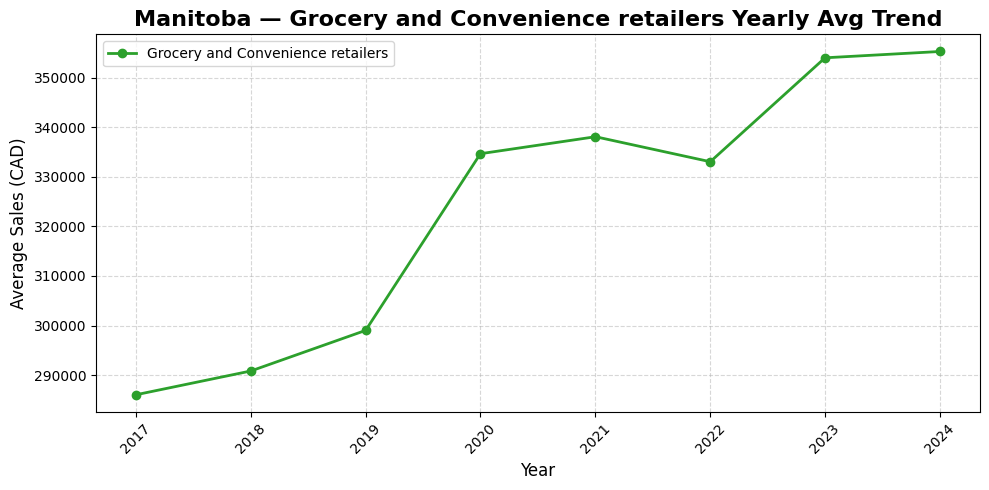

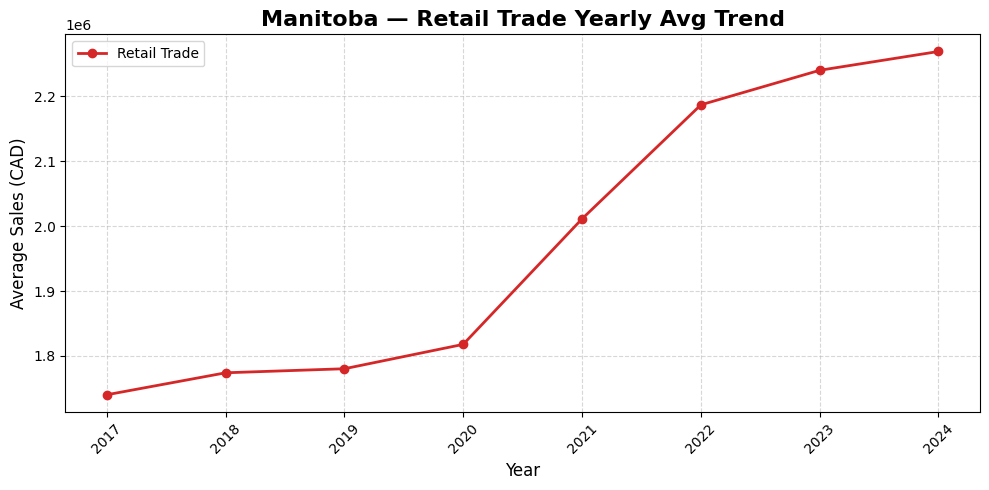

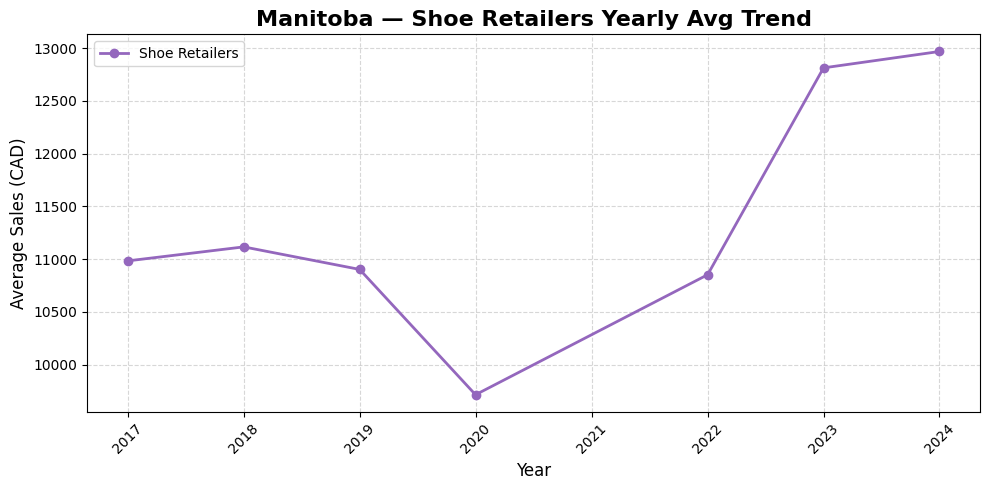

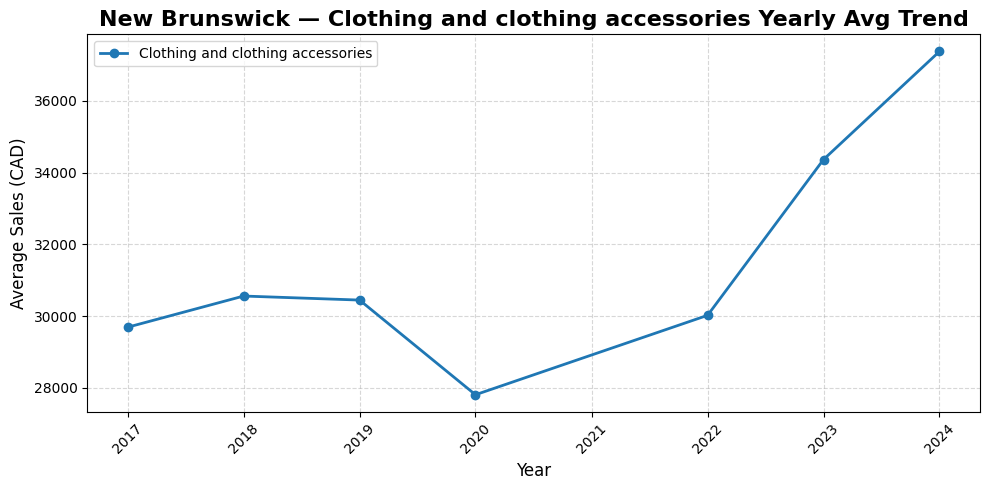

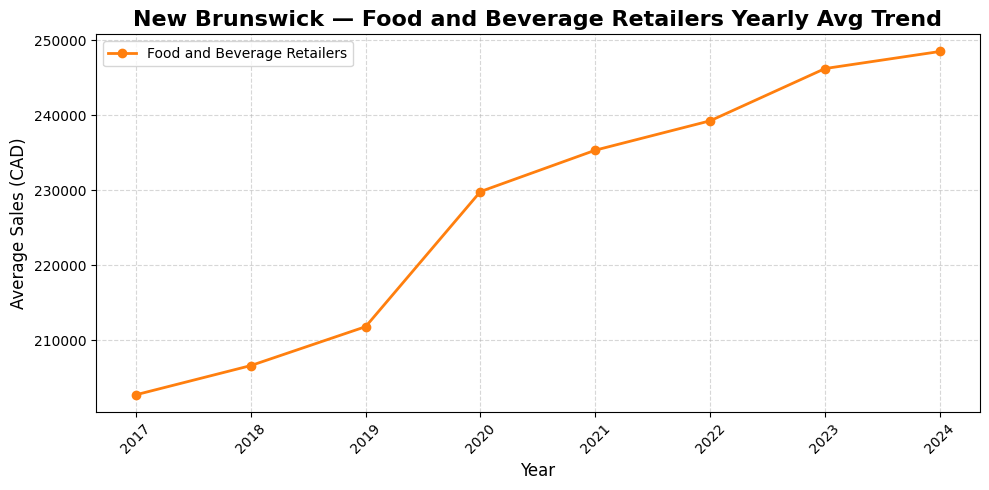

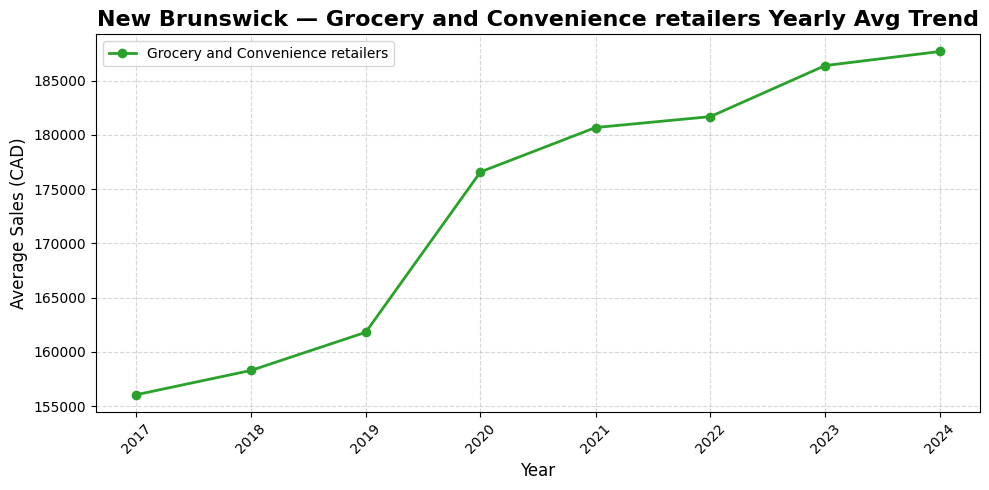

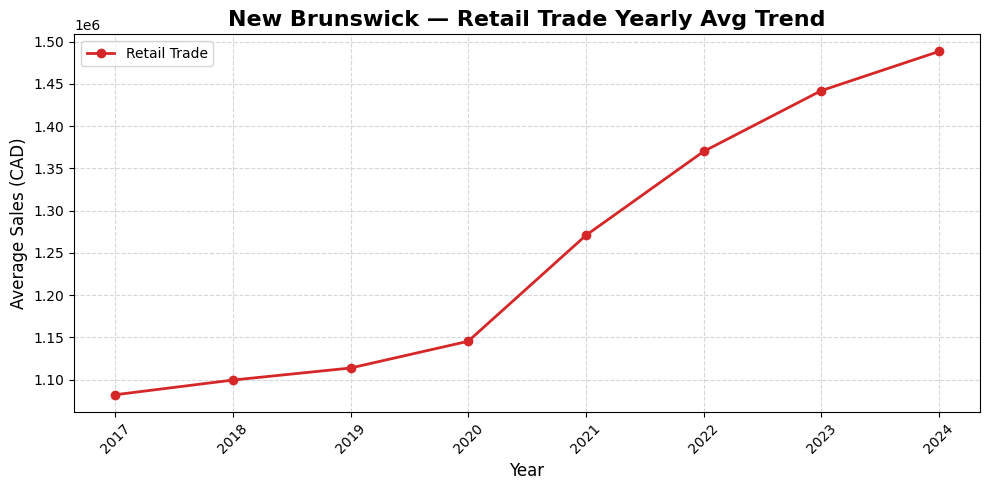

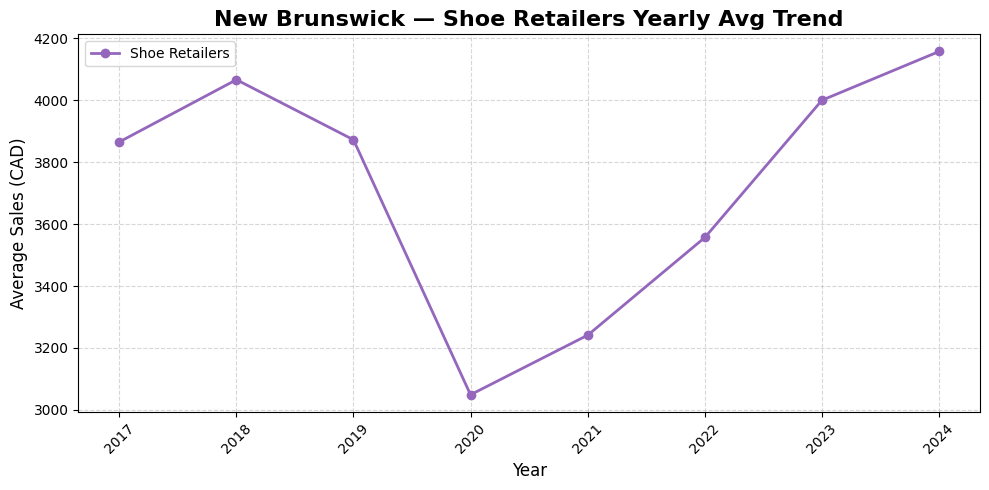

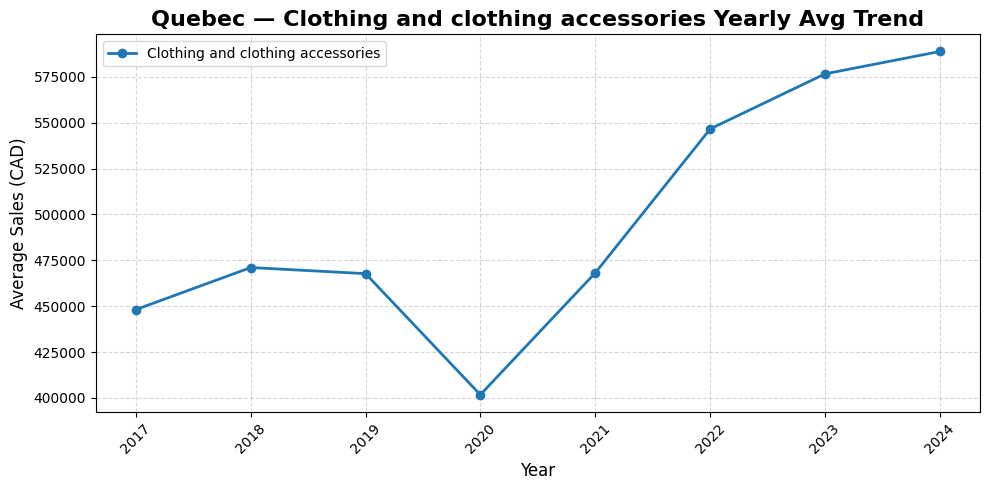

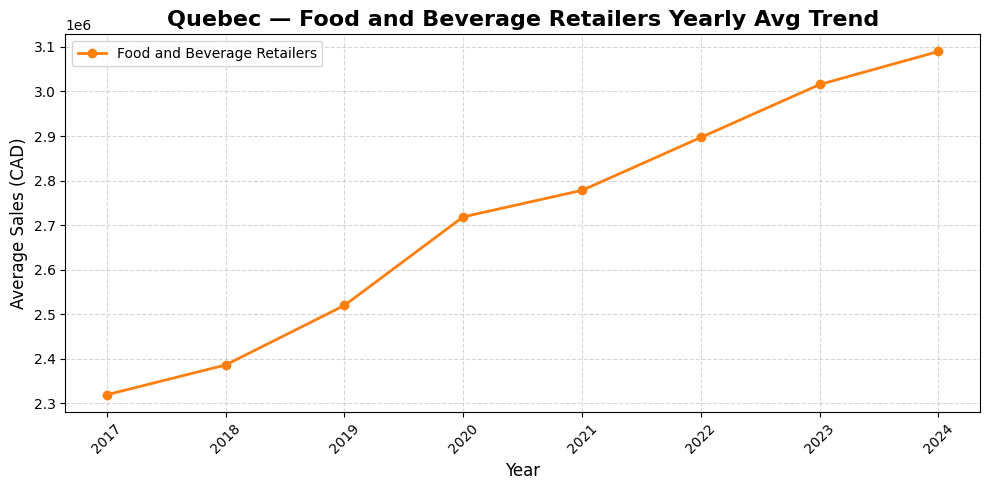

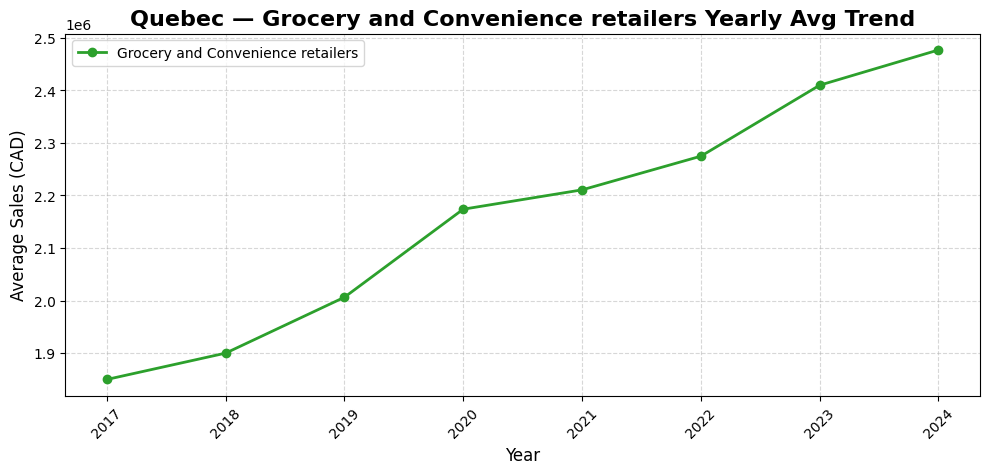

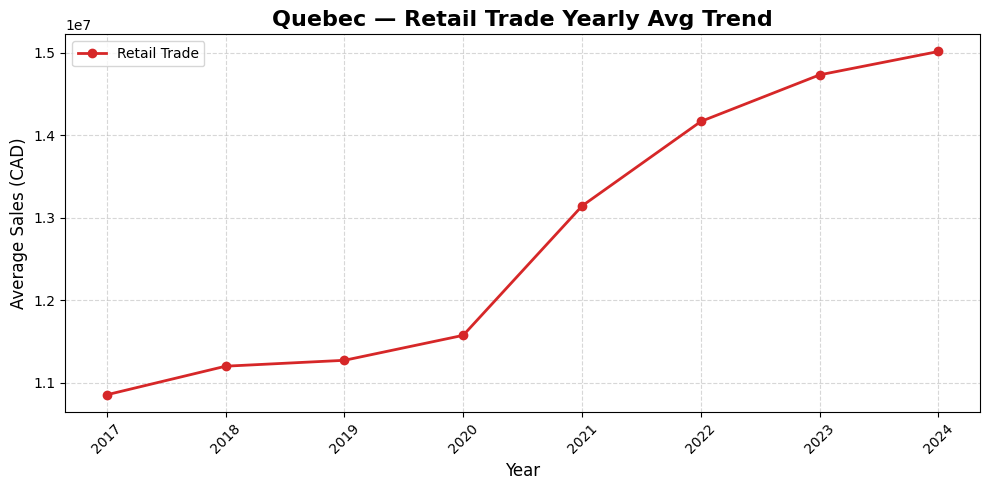

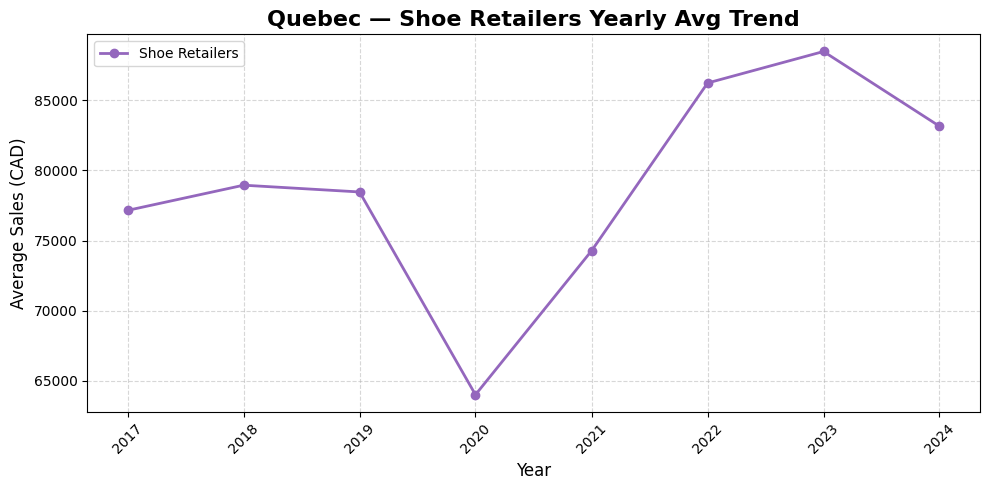

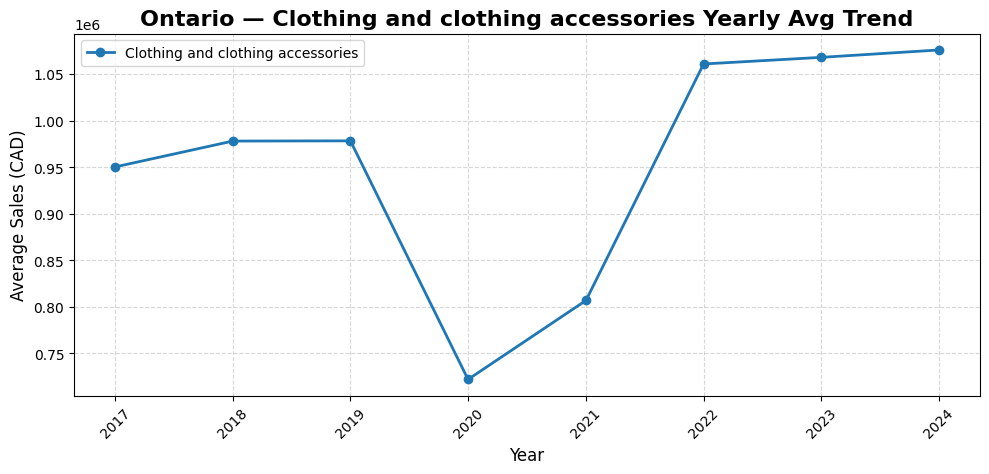

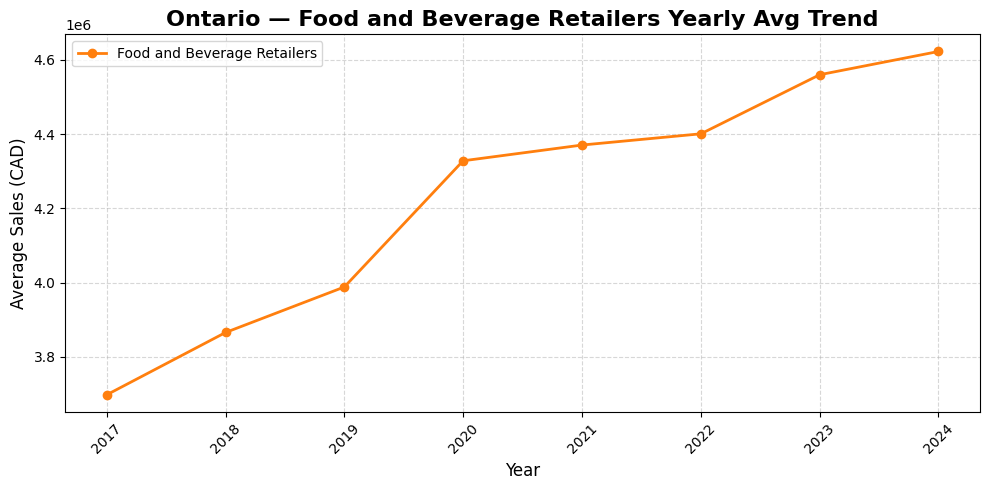

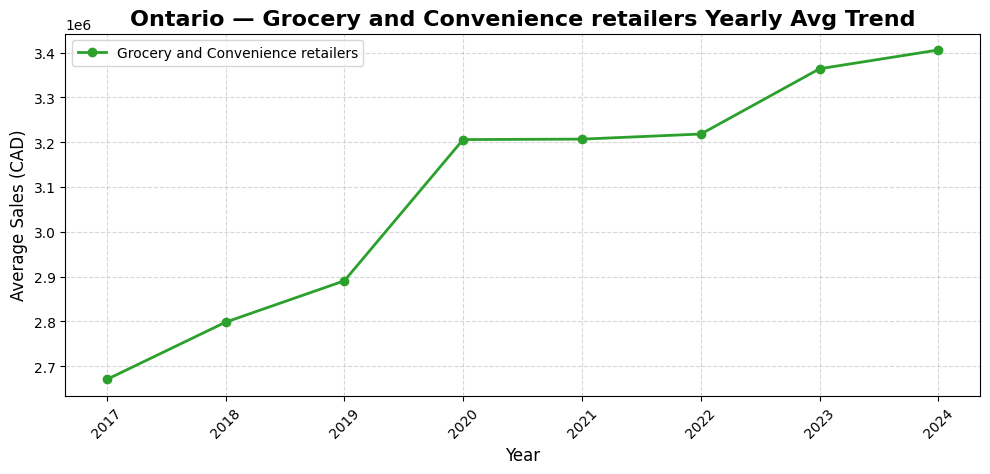

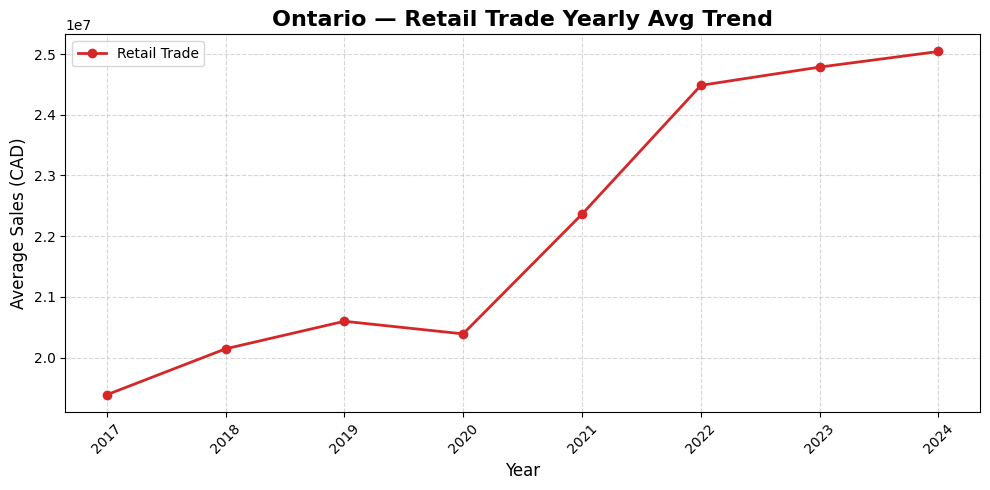

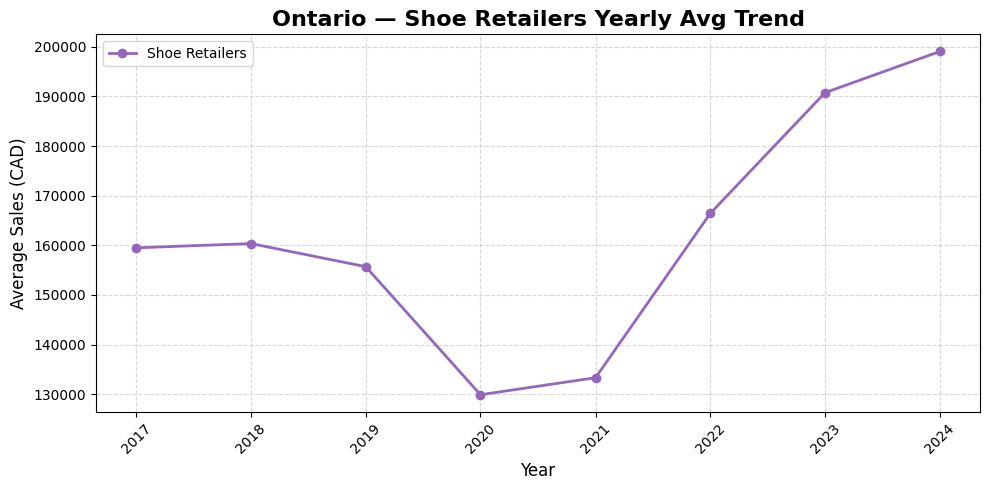

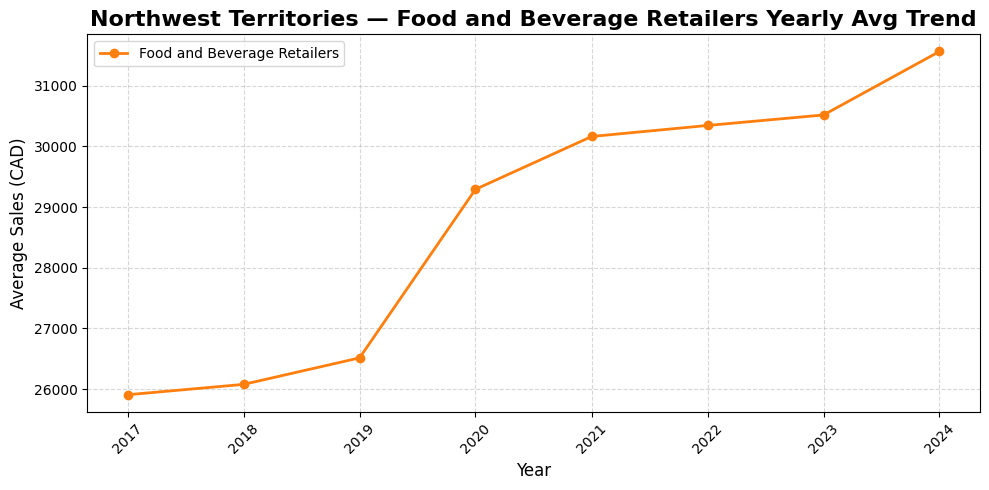

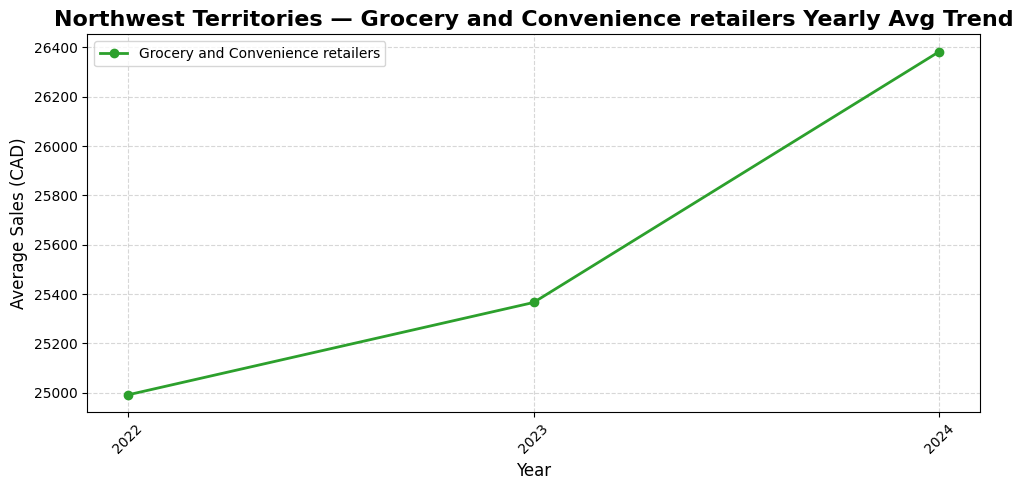

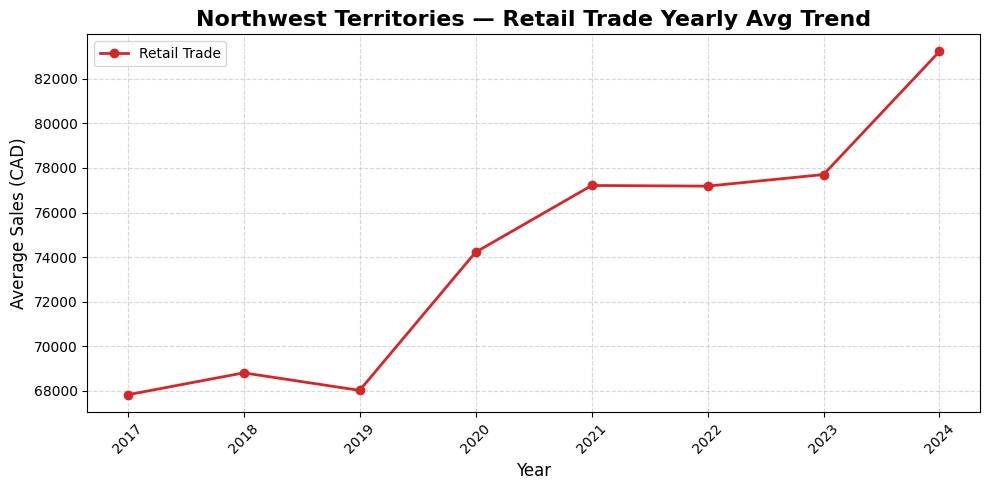

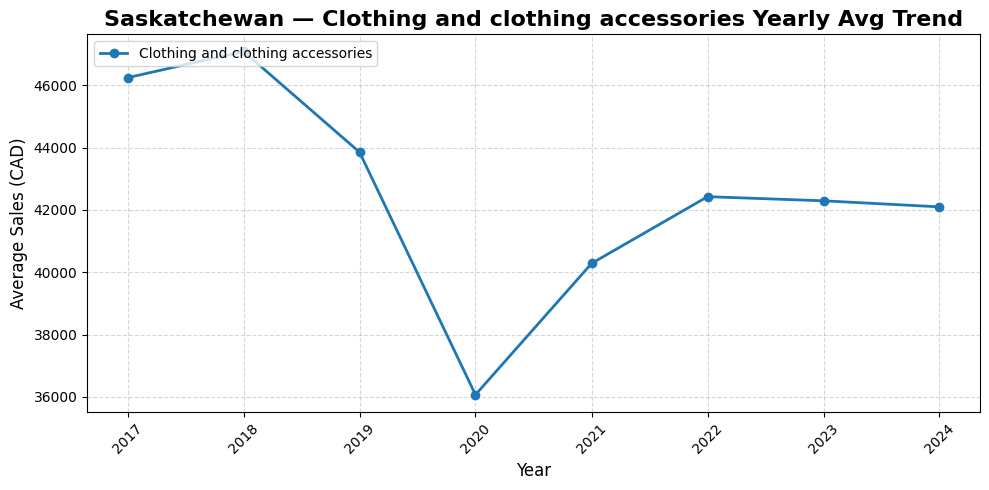

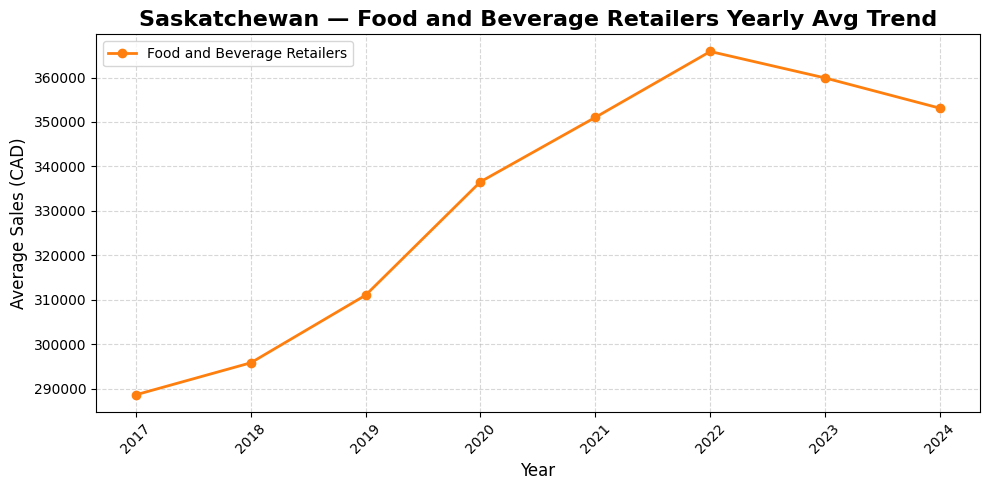

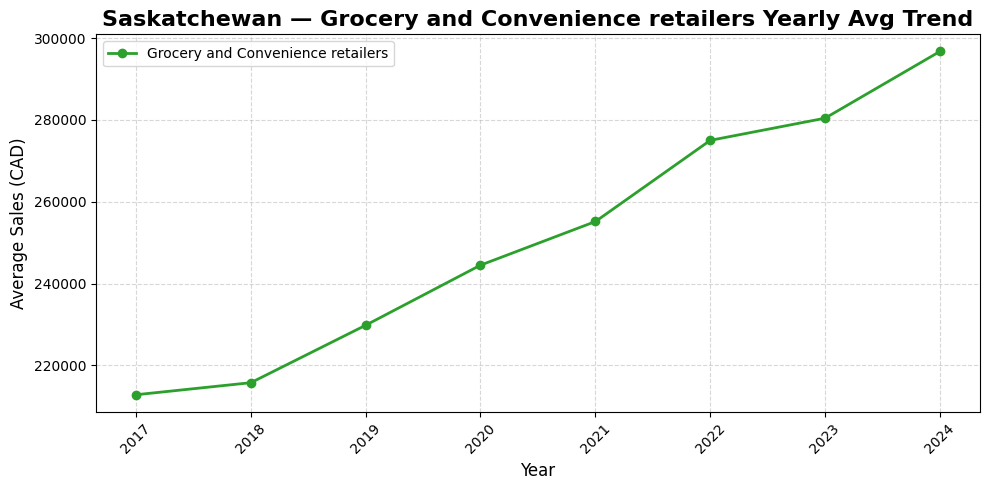

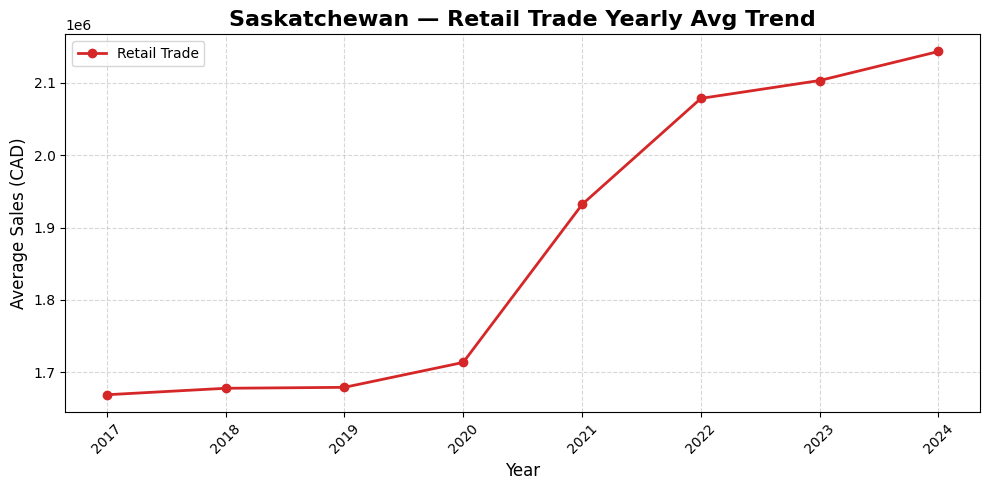

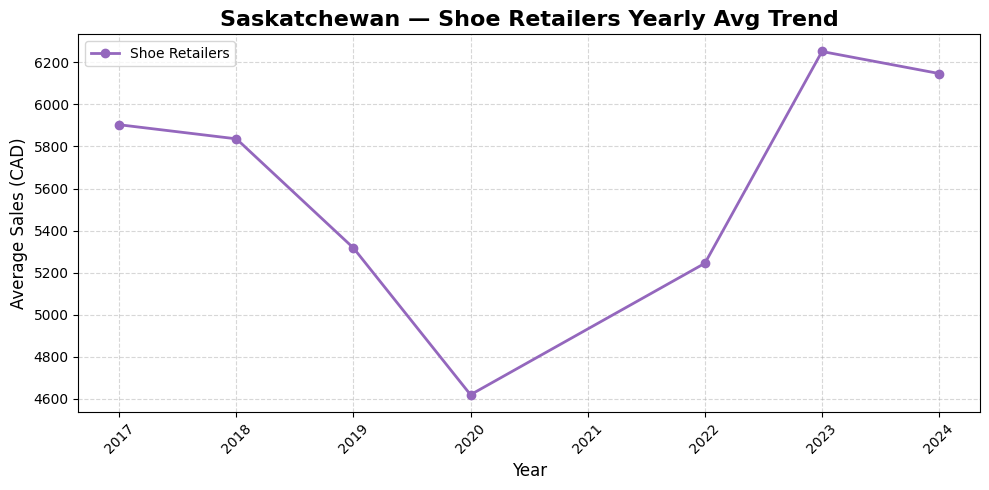

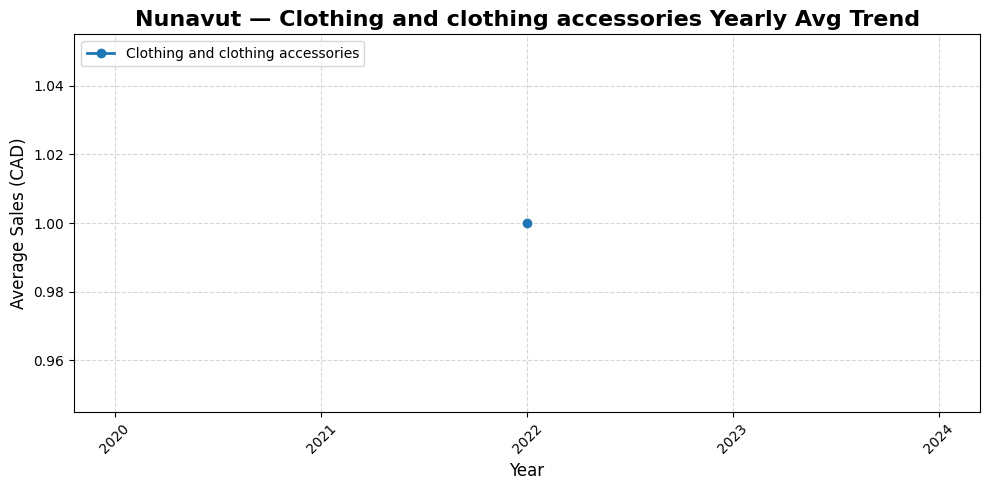

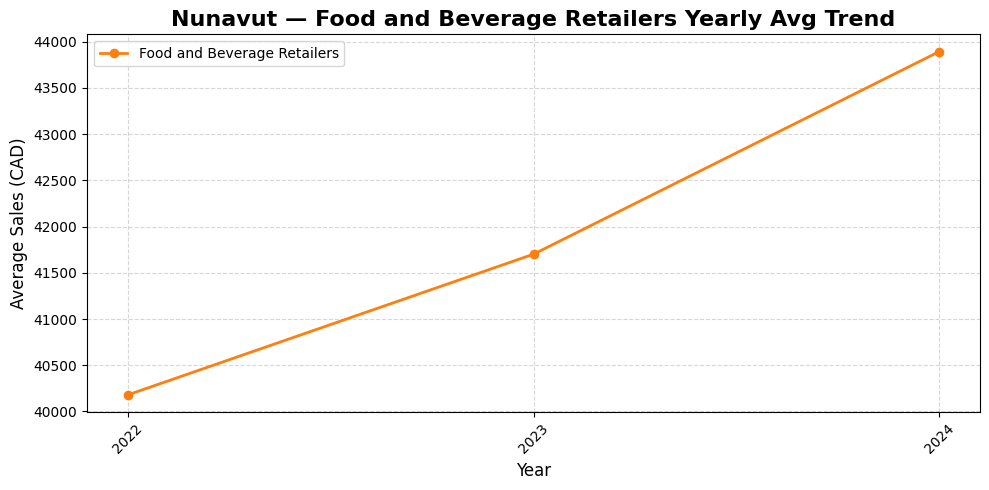

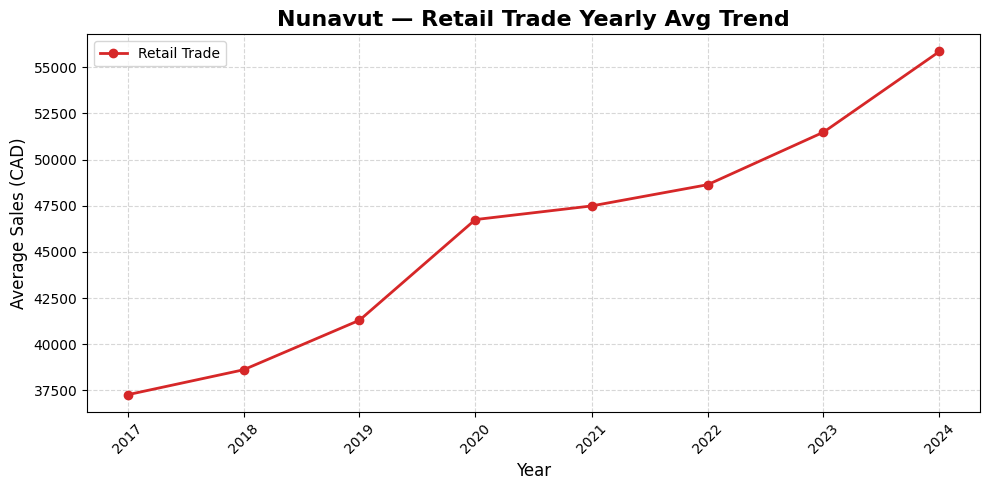

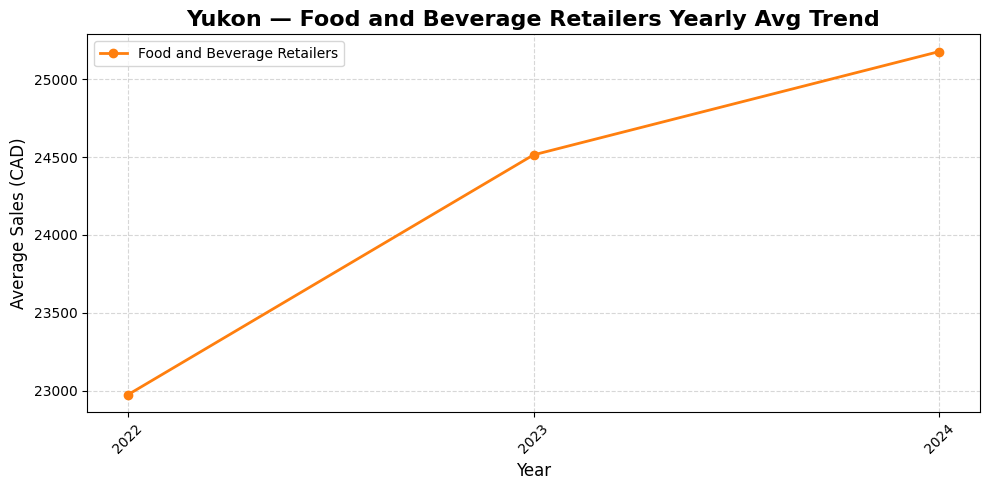

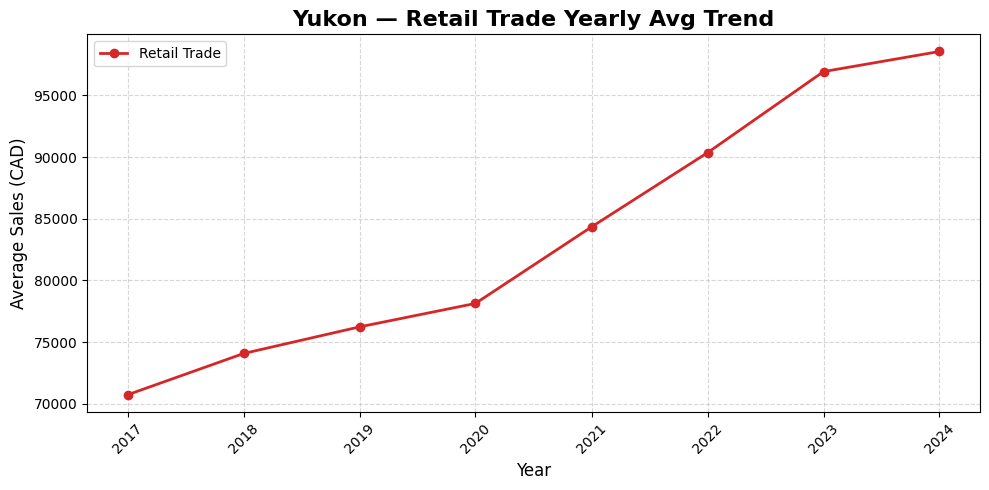

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Load data and add Date column
df = pd.read_excel("/content/Final data_1.xlsx", sheet_name="Retail Trade")
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# 2. Parameters
provinces = df['Province'].unique()
period = 12  # 12 months
cmap = plt.get_cmap('tab10')

# 3. Loop over provinces
for province in provinces:
    df_prov = df[df['Province'] == province]
    pivot = df_prov.pivot(index='Date', columns='Category', values='Value')
    categories = pivot.columns.tolist()
    color_map = {cat: cmap(i % cmap.N) for i, cat in enumerate(categories)}

    # 4. Plot each category’s yearly‐avg trend
    for cat in categories:
        ts = pivot[cat].dropna()
        if ts.empty:
            continue

        # decompose if enough data, else rolling‐mean fallback
        if len(ts) >= 2 * period:
            dec = seasonal_decompose(ts, model='additive', period=period)
            trend = dec.trend
        else:
            trend = ts.rolling(window=period, center=True, min_periods=1).mean()

        # drop NaNs and compute yearly average
        trend = trend.dropna()
        yearly_avg = trend.groupby(trend.index.year).mean()

        # Convert the integer year index to datetime
        yearly_avg.index = pd.to_datetime(yearly_avg.index.astype(str) + '-01-01')

        # 5. Plot
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(
            yearly_avg.index,
            yearly_avg.values,
            marker='o', linestyle='-',
            linewidth=2, markersize=6,
            color=color_map[cat],
            label=cat
        )

        # 6. X-axis: one tick per year, formatted YYYY
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.tick_params(axis='x', rotation=45)

        # 7. Styling
        ax.set_title(f"{province} — {cat} Yearly Avg Trend", fontsize=16, weight='bold')
        ax.set_xlabel("Year", fontsize=12)
        ax.set_ylabel("Average Sales (CAD)", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(loc='upper left')

        plt.tight_layout()

        # Display the plot
        plt.show()
